# Passing map analysis

In [372]:
# imports
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from mplsoccer import Pitch

In [373]:
# read data
df = pd.read_csv('../data/processed_timelines.csv')

In [374]:
# ignore all other events than passes
df_passes = df[df['event_type'] == 'Pass']

In [375]:
# match_home_mask = (df_passes.match_id == 3275) & (df_passes.team == 'Away') & (df_passes.period == 2)
# df_passes = df_passes.loc[match_home_mask, ['start_position_x', 'start_position_y', 'end_position_x', 'end_position_y', 'result']]

In [376]:
# define basic pitch creation
def create_pitch():

    # Customize the pitch
    pitch = Pitch(
        pitch_type='skillcorner', # Centered indexing
        pitch_length=100,
        pitch_width=63,
        pitch_color='gray',  # Background color
        line_color='black',   # Line color
        axis=True,
        label=False,
        stripe=False,          # Add stripes to the pitch
        corner_arcs=True,     # Draw corner arcs
        goal_type='box'
    )
    
    return pitch  

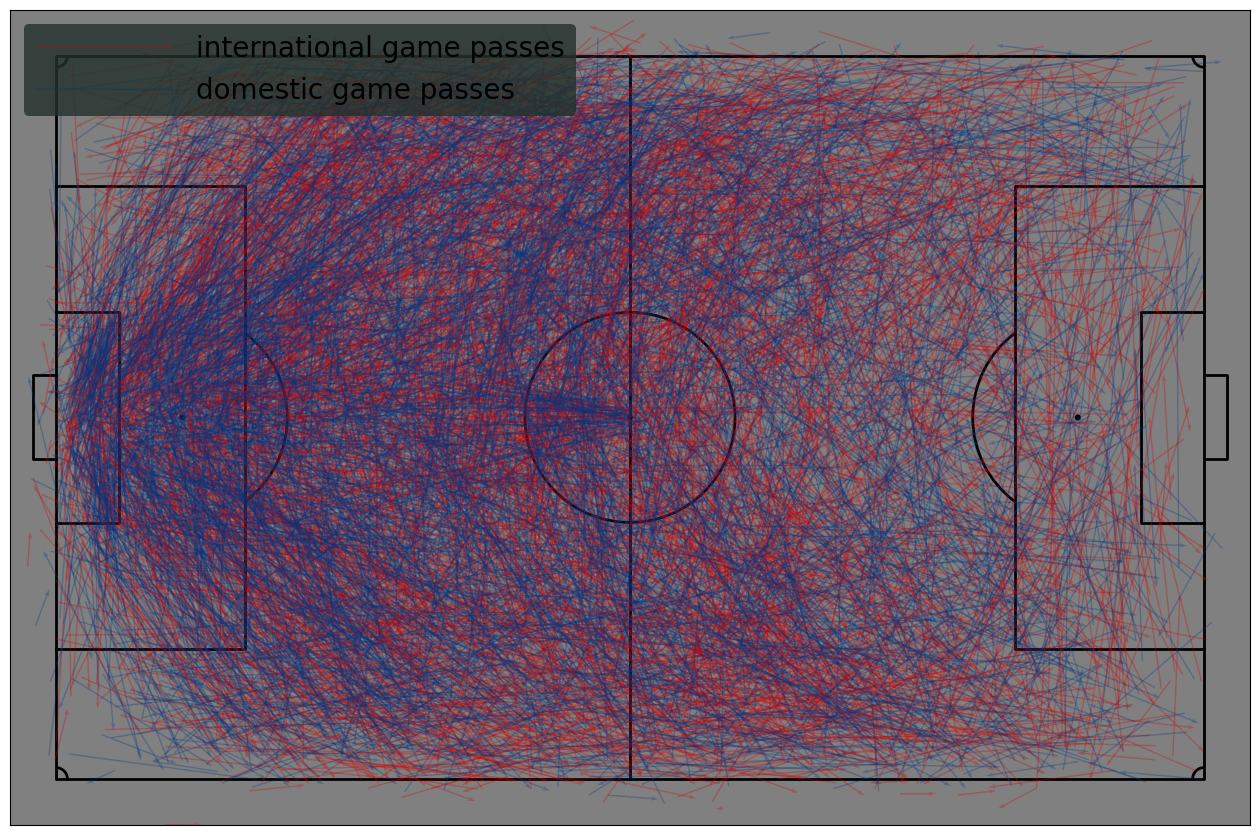

In [401]:
# Plot the completed passes
pitch = create_pitch()

fig, ax = pitch.draw(figsize=(16, 11), constrained_layout=True, tight_layout=False)  # Adjust figure size

df_passes_home_m14_int = df.loc[(df['event_type'] == 'Pass') & (df['result'] == 'Successful') & (df['team'] == 'Home') & (df['age'] == 'M14') & (df['int_level'] == 1)]
df_passes_home_m14_dom = df.loc[(df['event_type'] == 'Pass') & (df['result'] == 'Successful') & (df['team'] == 'Home') & (df['age'] == 'M14') & (df['int_level'] == 0)]

# Plot the completed passes
pitch.arrows(df_passes_home_m14_int.start_position_x, df_passes_home_m14_int.start_position_y,
             df_passes_home_m14_int.end_position_x, df_passes_home_m14_int.end_position_y,
             width=1, color='#d50000', alpha=0.3, ax=ax, label='international game passes')

pitch.arrows(df_passes_home_m14_dom.start_position_x, df_passes_home_m14_dom.start_position_y,
             df_passes_home_m14_dom.end_position_x, df_passes_home_m14_dom.end_position_y,
             width=1, color='#003580', alpha=0.3, ax=ax, label='domestic game passes')

# Set up the legend
ax.legend(facecolor='#22312b', handlelength=5, edgecolor='None', fontsize=20, loc='upper left')

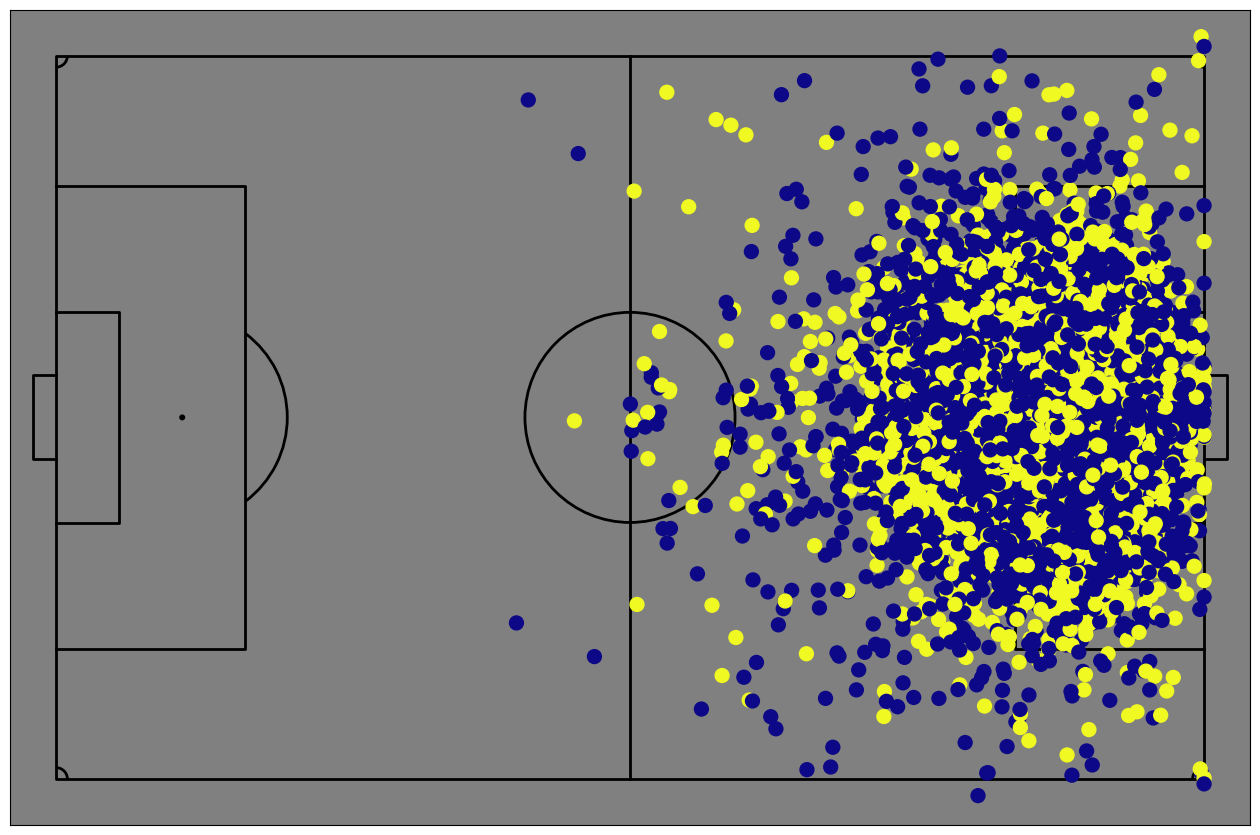

In [393]:
# plot some shots
df_shots = df[df['event_type'] == 'Shot']

pitch = create_pitch()

fig, ax = pitch.draw(figsize=(16, 11), constrained_layout=True, tight_layout=False)  # Adjust figure size

df_shots_home = df_shots.loc[(df_shots['team'] == 'Home')]
df_shots_away = df_shots.loc[(df_shots['team'] == 'Away')]

# Plot the completed passes
pitch.scatter(df_shots_home.start_position_x, df_shots_home.start_position_y,
             s=100, cmap='plasma_r', c=df_shots_home.int_level, ax=ax)
pitch.scatter(df_shots_away.start_position_x*(-1), df_shots_away.start_position_y*(-1),
             s=100, cmap='plasma_r', c=df_shots_away.int_level, ax=ax)

In [379]:
# df[(df['match_id'] == 2247) & (df['event_type'] == 'Shot')]

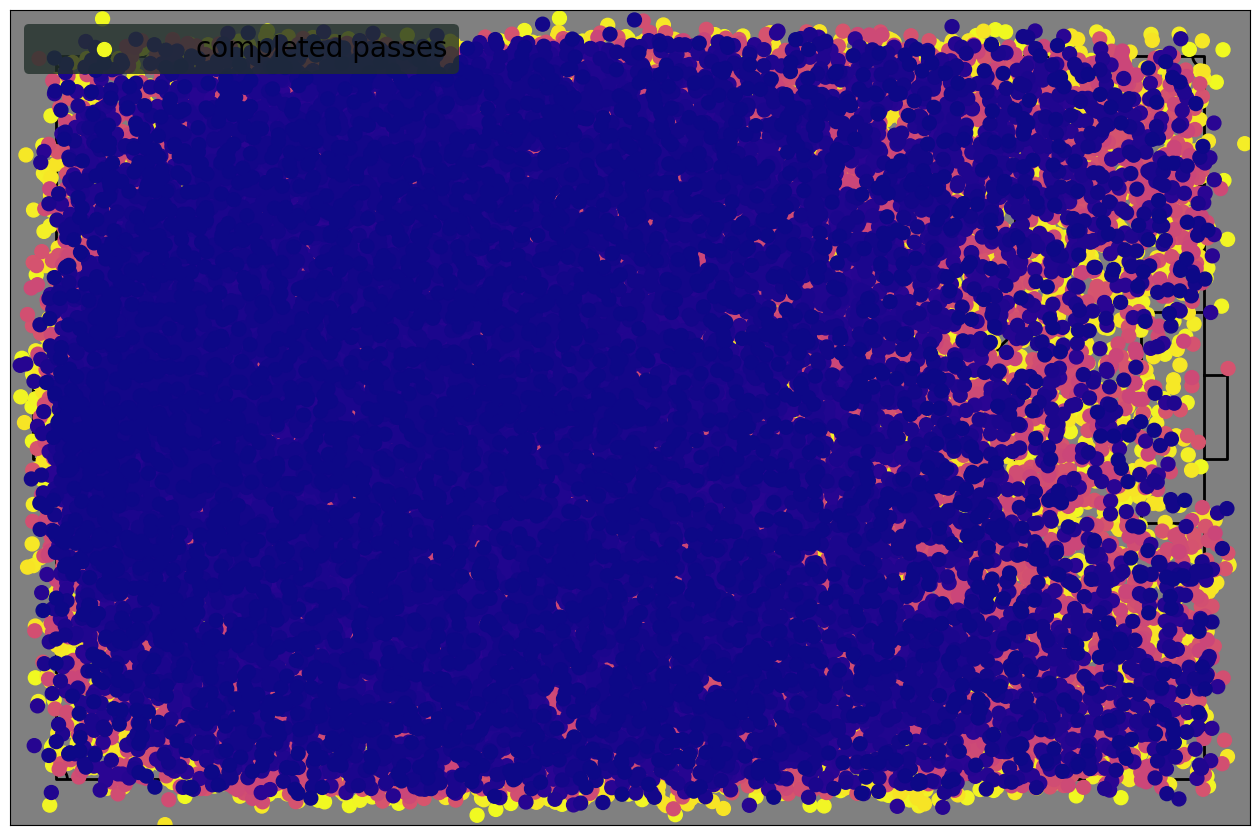

In [380]:
pitch = create_pitch()

fig, ax = pitch.draw(figsize=(16, 11), constrained_layout=True, tight_layout=False)  # Adjust figure size

df_passes_home = df_passes[df_passes['team'] == 'Home']


# Plot the completed passes
pitch.scatter(df_passes_home.start_position_x, df_passes_home.start_position_y,
             s=100, cmap='plasma_r', c=df_passes_home.tournament_id, ax=ax, label='completed passes')


# Set up the legend
ax.legend(facecolor='#22312b', handlelength=5, edgecolor='None', fontsize=20, loc='upper left')

In [381]:
matches = pd.read_csv('../data/match_info.csv')
dimensions = pd.read_csv('../data/pitch_dimensions.csv')

In [382]:
matches = matches.drop(columns=['home_team_int', 'away_team_int', 'int_level'])

In [383]:
comb = matches.merge(dimensions, on='match_id', how='inner')

In [384]:
comb[['age', 'pitch_length', 'pitch_width']].value_counts().reset_index(name='count')

,age,pitch_length,pitch_width,count
0,M14,100,63,87
1,M12,100,63,82
2,F14,100,63,74
3,F13,100,63,68
4,M13,100,63,65
5,F12,63,40,54
